# 第三章　一般化線形モデル(GLM)

統計モデルを観測データに当てはめること：**回帰**

説明変数を組み込んだ統計モデル：**一般化線形モデル**

## 3.1 

In [2]:
import requests
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [8]:
data = pd.read_csv('sample_data/data3a.csv')

# i=0~49は何も特別な処理をされていない種子データ
data.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


In [10]:
# i=50~99は施肥処理をされた種子データ
data.tail()

,y,x,f
95,8,9.15,T
96,6,8.52,T
97,8,10.24,T
98,7,10.86,T
99,9,9.97,T


## 3.2 データの概要を調べる

In [12]:
# 各列の型
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       100 non-null    int64  
 1   x       100 non-null    float64
 2   f       100 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 2.5+ KB


In [11]:
# fの値の分布
data['f'].value_counts()

C    50
T    50
Name: f, dtype: int64

In [13]:
# y列とx列の要約統計量
data.describe()

,y,x
count,100.000000,100.000000
mean,7.830000,10.089100
std,2.624881,1.008049
min,2.000000,7.190000
25%,6.000000,9.427500
50%,8.000000,10.155000
75%,10.000000,10.685000
max,15.000000,12.400000


## 3.3 統計モデリングの前にデータを図示する

モデリングする前に視覚的にデータをよく見ることが大事

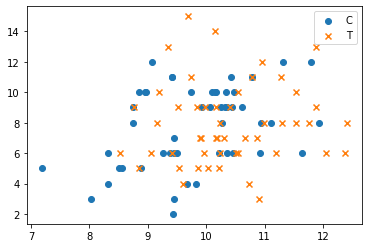

In [14]:
# 散布図
plt.scatter(data[data['f']=='C']['x'], data[data['f']=='C']['y'], marker='o', label='C')
plt.scatter(data[data['f']=='T']['x'], data[data['f']=='T']['y'], marker='x', label='T')
plt.legend(loc='best')
plt.show()

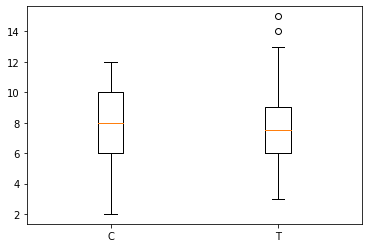

In [15]:
# 箱ひげ図
fig, ax = plt.subplots()
ax.boxplot([data[data['f']=='C']['y'], data[data['f']=='T']['y']])
ax.set_xticklabels(['C', 'T'])
plt.show()

## 3.4 ポアソン回帰の統計モデル

二章では平均種子数$\lambda$が全個体で共通の値であると仮定した上で、平均$\lambda$のポアソン分布で説明できるとした<br>
この章では個体ごとの平均種子数$\lambda_i$が体サイズx, 施肥処理fに影響されるようなモデルを設計する

個体iの体サイズ$x_i$だけに依存する統計モデルについて考える<br>
説明変数は体サイズ$x_i$, 応答変数は種子数$y_i$, 施肥効果$f_i$は一旦無視

ある個体iの種子数が$y_i$である確率$p(y_i \mid \lambda_i)$はポアソン分布に従うと仮定する
$$
p(y_i | \lambda) = \frac{\lambda^{y_i}exp(-\lambda)}{y_i!}
$$

### 3.4.1 線形予測子と対数リンク関数

平均$\lambda_i$を説明変数である体サイズ$x_i$の関数で定義する
$$
\lambda_i = exp(\beta_1 + \beta_2 x_i)
$$
以下の形に変形できる
$$
log \lambda_i = \beta_1 + \beta_2 x_i
$$
右辺$\beta_1 + \beta_2 x_i$は線形予測子と呼ぶ

($\lambda_i$の関数) = (線形予測子)<br>
となっている場合、左側の関数をリンク関数と呼ばれる<br>

今回の場合は**対数リンク関数**と呼ばれ、ポアソン回帰する場合は大体は対数リンク関数<br>
ポアソン回帰のGLMで対数リンク関数を使う理由は、これが推定計算に都合よくかつわかりやすいから

推定計算に都合が良い理由: $\lambda_i = exp(線形予測子) \geqq 0$となっているところ<br>
ポアソン分布の平均は非負でなければならず、対数リンク関数を使うと説明変数やパラメータがどのような値になってもこの条件が守られるので最尤推定値の探索に便利だから

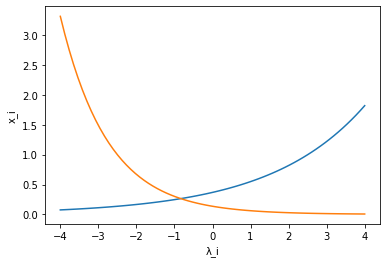

In [23]:
# 参考：pythonでの関数の描画 https://pianofisica.hatenablog.com/entry/2020/09/16/120000

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace( -4, 4, 70)   # linspace(min, max, N) で範囲 min から max を N 分割します
y = np.exp(-1 + 0.4*x )
plt.plot(x,y)

p = np.linspace( -4, 4, 70)   # linspace(min, max, N) で範囲 min から max を N 分割します
q = np.exp(-2 - 0.8*p )
plt.plot(p, q)

plt.xlabel('λ_i')
plt.ylabel('x_i')

plt.show()

個体iの平均種子数$\lambda_i$と体サイズ$x_i$の関係

オレンジ：$\{\beta_1, \beta_2\} = \{-2, -0.8\}$<br>
ブルー：$\{\beta_1, \beta_2\} = \{-1, -0.8\}$

### 3.4.2 当てはめと当てはまりの良さ

ポアソン回帰：観測データに対するポアソン分布を使った統計モデルの当てはめ
ポアソン回帰：対数尤度$logL$が最大になるパラメータ$\beta_1, \beta_2$の推定値を決めること

このモデルの尤度は二章より以下で表される
$$
L(\lambda_i) = \prod_i{p(y_i \mid \lambda_i)} = \prod_i{\frac{\lambda_i^{y_i}exp(-\lambda_i)}{y_i!}}
$$
対数尤度logLは以下
$$
logL(\lambda_i) = \sum_i log \frac{\lambda_i^{y_i}exp(-\lambda_i)}{y_i!} \\
logL(\beta_1, \beta_2) = \sum_i log \frac{\lambda_i^{y_i}exp(-\lambda_i)}{y_i!}
$$

線形予測子は$log\lambda_i = \beta_1 + \beta_2x_i$で$\lambda_i$が$\beta_1, \beta_2$の関数であることに注意

$\beta_1, \beta_2$の２変数を同時に扱うので、二章の時のように解析的な導出は難しい<br>
そのためpythonのモデルに頼った数値的な試行錯誤で導出する

In [30]:
# statsmodelのGLMを活用する
# 公式　https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [31]:
model = smf.glm(
    "y ~ x", # "目的変数 ~ 説明変数"
    data, # 対象データのDF
    family=sm.families.Poisson() # ポアソン回帰
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Sun, 17 Apr 2022   Deviance:                       84.993
Time:                        02:53:33   Pearson chi2:                     83.8
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04414
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2917      0.364      3.552      0.000       0.579       2.005
x              0.0757      0.036      2.125      0.034       0.006       0.145
==============================================================================
"""

#### coef
coefの項が推定値

Interceptが切片 $\beta_1$<br>, xが傾き $\beta_2$に対応している

最尤推定値は$\beta_1=1.29, \beta_2=0.0757$であるとわかる。
$$
log \lambda_i = 1.29 + 0.0757 x_i
$$

#### Std error
Std errorの項はパラメータの標準誤差の推定値<br>
この場合には推定値$\beta_1, \beta_2$のばらつきを標準誤差で表したもの。<br>
ここの標準誤差の意味：「同じ調査方法で同数の別データを取り直してみたりすると、最尤推定値も変わるので、そのばらつき具合」

Q. ここでいうStd Errorって？<br>
A. 対数尤度は最尤推定値で最大値となる凸関数であり、推定のばらつきが正規分布であると仮定して、対数尤度関数は最大値付近の形が正規分布に近いと仮定した場合にStd Errorが得られる

#### z
最尤推定値をStd Errorで除した値<br>
これを用いてWald信頼区間を構築できて、推定値たちがゼロから十分に離れているかどうかの粗い目安になる

Wald統計量とも呼ばれる<br>
ロジスティック回帰とWald統計量について：https://best-biostatistics.com/correlation_regression/wald.html
#### P > $\mid z \mid$

このGLMの場合は、平均がz値の絶対値であり標準偏差が1の正規分布における<br>
-∞ ~ 0のまでの値を取る確率の二倍<br>
この確率が大きいほどz値がゼロに近くなり、推定値$\beta_1, \beta_2$がゼロに近いことを表現する１つの方法

これをいわゆるP値に見立てて簡易的な検定に使う場合もある

ある説明変数をモデルに含めるか否かの判断は、Wald信頼区間を用いるのではなく4章で紹介するモデル選択を使った方が良い<br>
Wald => 当てはまりの改善<br>
モデル選択 => この説明変数を入れるかどうか. 予測の改善

#### Log-Likelihood あてはまりの良さ

最大対数尤度をあてはまりの良さと呼ぶ

対数尤度$logL(\beta_1, \beta_2)$が最大になっているところ<br>
今回の最大対数尤度は-235.4だとわかる